### Sklearn Out of Core Classifiers
The dataset created from 300 LSI features per question is quite
large and various machine learning operations cannot be applied
directly on the entire dataset. For this reason, in this notebook
we experiment with three of the out-of-core classifiers in the 
Sci-kit Learn Library. 

In [1]:
# import needed modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# define filenames and related dimensions
topics_filename = 'lsi_data300b_all.csv'
train_filename = 'train.csv'
test_filename = 'test.csv'
data_nrec = 808580
data_ncol = 600
minibatch_size = 1000

In [3]:
# create a function that yields a minibatch from the training set
def iter_minibatches(topfn, trainfn, minibatch_size):
    """Generator of minibatches."""
    
    x_reader = pd.read_csv(topfn, header=None, 
                          skiprows=0, 
                          chunksize=minibatch_size)
    
    y_reader = pd.read_csv(trainfn, header=None,
                           skiprows=1,
                           chunksize=minibatch_size)
    
    X_ = x_reader.next()
    df = y_reader.next()
    X_ = X_.drop(data_ncol,1)
    y_ = df.iloc[:,-1]
    del df
    
    while len(X_):
        yield normalize(X_.values), y_.values

        X_ = x_reader.next()
        df = y_reader.next()
        X_ = X_.drop(data_ncol,1)
        y_ = df.iloc[:,-1]
        del df
    

In [4]:
# import classifier libraries
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import time

In [5]:
# classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(loss = 'modified_huber', n_jobs = -1, n_iter = 1000),
    'Perceptron': Perceptron(),
    #'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}

In [6]:
# function to print classifier statistics as progress indicators
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s

In [7]:
minibatch_size = 1000
minibatch_iterators = iter_minibatches(topics_filename, train_filename,
                                       minibatch_size)

#### Iterative Learning 
We use the partial_fit method of the classifiers to incrementally learn
the prediction model

In [8]:
total_vect_time = 0.0
all_classes = np.array([0, 1])

# initialize classifier statistics data structure
cls_stats = {}
for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             't0': time.time(), 'runtime_history': [0], 
             'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

# Main loop : iterate on mini-batches of examples
for i, (X_train, y_train) in enumerate(minibatch_iterators):
    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        #print 'now doing partial fit'
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        run_history = total_vect_time + cls_stats[cls_name]['total_fit_time']
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 20 == 0:
            print progress(cls_name, cls_stats[cls_name])
    if i % 20 == 0:
        print '\n'
print progress(cls_name, cls_stats[cls_name])
print '\n'
    

  Passive-Aggressive classifier : 	  1000 train docs (   380 positive) in 0.28s ( 3521 docs/s)
          Perceptron classifier : 	  1000 train docs (   380 positive) in 0.28s ( 3521 docs/s)
                 SGD classifier : 	  1000 train docs (   380 positive) in 0.30s ( 3333 docs/s)


  Passive-Aggressive classifier : 	 21000 train docs (  7832 positive) in 4.27s ( 4921 docs/s)
          Perceptron classifier : 	 21000 train docs (  7832 positive) in 4.27s ( 4916 docs/s)
                 SGD classifier : 	 21000 train docs (  7832 positive) in 4.27s ( 4912 docs/s)


  Passive-Aggressive classifier : 	 41000 train docs ( 15267 positive) in 8.30s ( 4940 docs/s)
          Perceptron classifier : 	 41000 train docs ( 15267 positive) in 8.30s ( 4937 docs/s)
                 SGD classifier : 	 41000 train docs ( 15267 positive) in 8.31s ( 4935 docs/s)


  Passive-Aggressive classifier : 	 61000 train docs ( 22762 positive) in 12.21s ( 4994 docs/s)
          Perceptron classifier : 	 61000 t

In [9]:
df = pd.read_csv(topics_filename, header=None)
df = df.drop(data_ncol,1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.116973,0.129336,-0.147529,-0.344232,-0.805465,-0.178602,0.165683,0.017523,0.217531,-0.163631,...,-0.012319,0.014212,-0.008204,0.027198,-0.015458,-0.051744,0.018734,-0.020440,-0.036383,0.110148
1,0.008437,0.006934,-0.002033,0.002181,0.001664,0.000304,0.007157,-0.001556,-0.005190,-0.002693,...,0.004264,0.002187,-0.014265,-0.005043,0.006914,0.002378,0.004651,0.001284,-0.001356,-0.017259
2,0.046586,0.192261,0.159185,-0.080548,-0.205002,0.869738,-0.128208,0.038212,-0.226068,-0.116199,...,-0.010866,0.013304,-0.003162,0.036234,-0.078597,-0.041592,0.085446,-0.074769,-0.006734,-0.004014
3,0.002213,0.003883,0.002442,0.000453,-0.001469,0.001377,-0.000406,0.000516,0.002220,-0.001168,...,-0.004613,0.001528,0.001364,0.001826,0.000211,-0.004134,-0.000354,-0.000339,-0.000942,0.001243
4,0.002961,0.005638,-0.001022,-0.000135,-0.003060,0.005387,-0.000589,-0.000900,-0.000269,0.001097,...,-0.004826,-0.003080,0.000188,0.011339,-0.006525,-0.009069,0.010759,0.012395,-0.005665,0.005812


In [10]:
df_text = pd.read_csv(train_filename).fillna("")
df_text.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
X = df.values
y = df_text.iloc[:,-1:].values.ravel()
del df_text

In [12]:
print len(X[0]), len(y)

600 404290


In [13]:
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.33, random_state=42)

#### Evaluate Performance

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

##### Accuracy and Confusion Matrices

In [15]:
for cls_name, cls in partial_fit_classifiers.items():
    y_pred = cls.predict(X_test)
    print 'confusion matrix :', confusion_matrix(y_test, y_pred)
    print 'accuracy :', accuracy_score(y_test, y_pred)

[[73053 10922]
 [36660 12781]]
0.643356119206
[[69966 14009]
 [35468 13973]]
0.629152425496
[[72518 11457]
 [32530 16911]]
0.670301912814


In [16]:
from sklearn.metrics import roc_curve, auc
%matplotlib inline

##### ROC Curves
We plot the ROC curves to see how the true positive rate changes with the false positive rate as we move the threshold. The area under the curve tells us how different our classifier is from a random classifier.

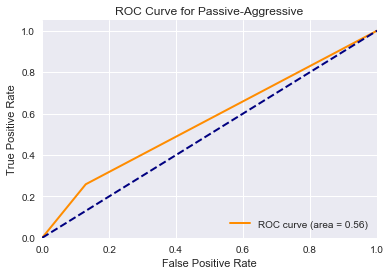

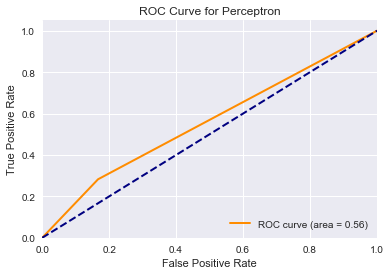

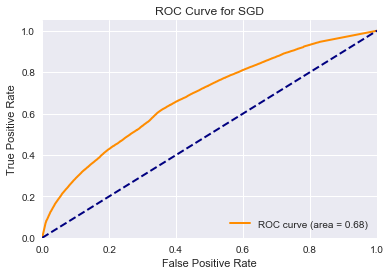

In [19]:
# plot the ROC curve and measure the area under curve
for cls_name, cls in partial_fit_classifiers.items():
    if cls_name == 'SGD':
        y_pred_prob = [i[1] for i in cls.predict_proba(X_test)]
    else:
        y_pred_prob = [i for i in cls.predict(X_test)]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for '+cls_name )
    plt.legend(loc="lower right")
    plt.show()

We see that we do not have the predict_proba() function in the Perceptron and the Passive-Aggressive classifier. That is why, the ROC curve is not proper.
We ignore that because the SGD has a better accuracy and confusion matrix.

##### Precision Recall Curve
We plot precision and recall curves to see the trade-off between the 
precision and recall for the classifiers

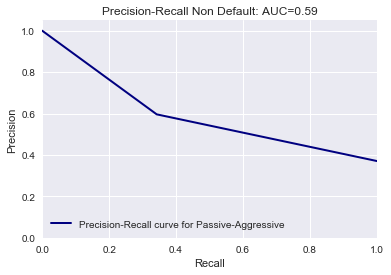

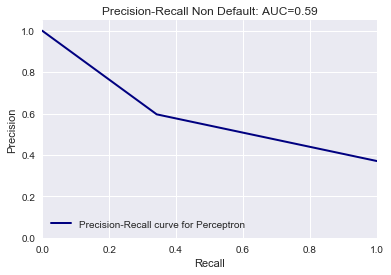

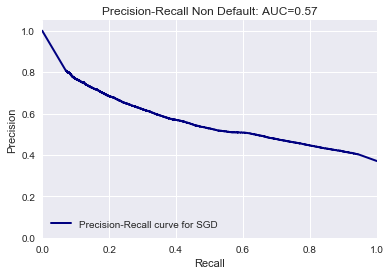

In [21]:
for cls_name, clf in partial_fit_classifiers.items():
    if cls_name == 'SGD':
        y_pred_prob = [i[1] for i in cls.predict_proba(X_test)]
    else:
        y_pred_prob = [i for i in cls.predict(X_test)]
    precision = dict()
    recall = dict()
    average_precision = dict()
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    average_precision = average_precision_score(y_test, y_pred_prob)
    
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, lw=lw, color='navy',
             label='Precision-Recall curve for '+cls_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Non Default: AUC={0:0.2f}'.format(average_precision))
    plt.legend(loc="lower left")
    plt.show()

Again, due to the unavailability of the probability estimates, the PR curves for the Perceptron and Passive-Aggressive classifiers are not smooth. We ignor this because we know from the accuracy and confusion matrix that the SGD is the best performer so far. We will continue our analysis with the SGD in another notebook.